#每个股票做卷积

对每个股票做一维卷积，让机器学习到一定长度的数据所有的特征，然后做出预测应该属于涨跌幅中的哪一类。

# 环境设置和变量设置

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
from tensorflow import  keras
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [4]:
root_path = Path('/gdrive/My Drive/data/tuShare')
%cd {root_path}
%ls

/gdrive/My Drive/data/tuShare
daily/            ReadMe.gdoc        trade_cal.csv
DiYiGe_model.png  stock_basic.csv    ts_all_code.csv
namechange.csv    stock_company.csv  ts_code_rows.csv


#先看看所有股票数据的信息
所有股票的信息归总在ts_code_rows.csv

In [5]:
code_rows = pd.read_csv(root_path/'ts_code_rows.csv')
code_rows.shape

(3754, 2)

In [6]:
code_rows.head()

,ts_code,rows
0,600689.SH,4000
1,600690.SH,4000
2,600691.SH,4000
3,600692.SH,4000
4,600693.SH,4000


In [7]:
code_rows.describe()

,rows
count,3754.000000
mean,2275.051945
std,1399.546126
min,0.000000
25%,855.500000
50%,2150.000000
75%,4000.000000
max,4000.000000


数据75%以上都有855条记录，也就是说有855个交易日，这样可以用这些数据，每个股票最近855个交易记录作为一条数据来学习

In [8]:
RECORD = 855 #交易记录条数
file_paths = ['daily/{}.csv'.format(code_row) for code_row in code_rows[code_rows['rows']>RECORD]['ts_code']]
file_paths

['daily/600689.SH.csv',
 'daily/600690.SH.csv',
 'daily/600691.SH.csv',
 'daily/600692.SH.csv',
 'daily/600693.SH.csv',
 'daily/600694.SH.csv',
 'daily/600695.SH.csv',
 'daily/600696.SH.csv',
 'daily/600697.SH.csv',
 'daily/600698.SH.csv',
 'daily/600699.SH.csv',
 'daily/600701.SH.csv',
 'daily/600702.SH.csv',
 'daily/600703.SH.csv',
 'daily/600704.SH.csv',
 'daily/600705.SH.csv',
 'daily/600706.SH.csv',
 'daily/600707.SH.csv',
 'daily/600708.SH.csv',
 'daily/600710.SH.csv',
 'daily/600711.SH.csv',
 'daily/600712.SH.csv',
 'daily/600713.SH.csv',
 'daily/600714.SH.csv',
 'daily/600715.SH.csv',
 'daily/600716.SH.csv',
 'daily/600717.SH.csv',
 'daily/600718.SH.csv',
 'daily/600719.SH.csv',
 'daily/600720.SH.csv',
 'daily/600721.SH.csv',
 'daily/600722.SH.csv',
 'daily/600723.SH.csv',
 'daily/600724.SH.csv',
 'daily/600725.SH.csv',
 'daily/600726.SH.csv',
 'daily/600727.SH.csv',
 'daily/600728.SH.csv',
 'daily/600729.SH.csv',
 'daily/600730.SH.csv',
 'daily/600731.SH.csv',
 'daily/600732.S

#探索个股数据

In [9]:
one_stock = pd.read_csv(root_path/file_paths[0])
one_stock.head()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,600689.SH,20191231,9.64,9.97,9.63,9.80,9.66,0.14,1.4493,38844.72,38199.835
1,600689.SH,20191230,9.52,9.68,9.41,9.66,9.57,0.09,0.9404,17645.70,16899.207
2,600689.SH,20191227,9.68,9.68,9.56,9.57,9.61,-0.04,-0.4162,12860.69,12367.035
3,600689.SH,20191226,9.56,9.65,9.55,9.61,9.54,0.07,0.7338,10453.60,10036.308
4,600689.SH,20191225,9.52,9.63,9.48,9.54,9.52,0.02,0.2101,12995.01,12426.958


In [10]:
#将日期转为星期，我认为星期几对股票交易有影响
one_stock['trade_date'] = pd.to_datetime(one_stock['trade_date'],format='%Y%m%d').dt.dayofweek
one_stock.head()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,600689.SH,1,9.64,9.97,9.63,9.80,9.66,0.14,1.4493,38844.72,38199.835
1,600689.SH,0,9.52,9.68,9.41,9.66,9.57,0.09,0.9404,17645.70,16899.207
2,600689.SH,4,9.68,9.68,9.56,9.57,9.61,-0.04,-0.4162,12860.69,12367.035
3,600689.SH,3,9.56,9.65,9.55,9.61,9.54,0.07,0.7338,10453.60,10036.308
4,600689.SH,2,9.52,9.63,9.48,9.54,9.52,0.02,0.2101,12995.01,12426.958


In [50]:
one_stock.columns

Index(['ts_code', 'trade_date', 'open', 'high', 'low', 'close', 'pre_close',
       'change', 'pct_chg', 'vol', 'amount'],
      dtype='object')

#数据流水线

###将分类热独编码 one-hot

In [11]:
pct_chg_category = dict(zip(np.arange(-10.0,11.0),np.arange(21)))#涨跌幅分为21类
pct_chg_category 

{-10.0: 0,
 -9.0: 1,
 -8.0: 2,
 -7.0: 3,
 -6.0: 4,
 -5.0: 5,
 -4.0: 6,
 -3.0: 7,
 -2.0: 8,
 -1.0: 9,
 0.0: 10,
 1.0: 11,
 2.0: 12,
 3.0: 13,
 4.0: 14,
 5.0: 15,
 6.0: 16,
 7.0: 17,
 8.0: 18,
 9.0: 19,
 10.0: 20}

##创建数据生成器
将数据目录传给生成器，返回处理好的数据信息

In [12]:
import random
#对数据集进行随机打乱
random.shuffle(file_paths)
test_split = int(len(file_paths) * 0.2)#20：80 测试集：训练集
train_file_paths = file_paths[test_split:]
test_file_paths = file_paths[:test_split]
val_split = int(len(train_file_paths)* 0.2) #20:80 验证集：训练集
val_file_paths = train_file_paths[:val_split]
train_file_paths = train_file_paths[val_split:]

print('训练集： {}条'.format( len(train_file_paths)))
print('验证集： {}条'.format( len(val_file_paths)))
print('测试集： {}条'.format( len(test_file_paths)))

训练集： 1802条
验证集： 450条
测试集： 563条


In [0]:

def gen_data(file_path):
  #数据生成函数
  
  data = pd.read_csv(root_path/file_path)
  #将日期转为星期，我认为星期几对股票交易有影响
  #data['trade_date'] = pd.to_datetime(data['trade_date'],format='%Y%m%d').dt.dayofweek
  data.pop('trade_date')
  data.pop('ts_code') #去除股票代码
  #data.pop('vol')
  #data.pop('amount')
  data['vol'] = data['vol']/10000  #这两个值太大了，缩小10000倍
  data['amount'] = data['amount']/10000  #这两个值太大了，缩小10000倍
  target = data.pop('pct_chg')
  #target = data['pct_chg']

  #数据处理
  data = data[1:RECORD] #前50天的数据做为参数
  #target = target[:5][]
  pct_chg = pct_chg_category[round(target.values[0])] #返回的是涨跌幅分类

  pct_chg_one_hot = tf.one_hot(pct_chg,len(pct_chg_category))

  #return data.values,target.values[0]
  return data.values,pct_chg_one_hot


def gen_train_data():
  for file_path in train_file_paths:
    #file_path = random.choice(train_file_paths)
    yield gen_data(file_path)

def gen_val_data():
  for file_path in val_file_paths:
    #file_path = random.choice(val_file_paths)
    yield gen_data(file_path)

def gen_test_data():
  for file_path in test_file_paths:
    yield gen_data(file_path)

查看生成器生成的数据

In [14]:
ds_k ,ds_v = next(iter(gen_train_data()))
ds_k

array([[ 6.05      ,  6.18      ,  6.02      , ...,  0.07      ,
         2.93162   ,  1.7957604 ],
       [ 6.2       ,  6.25      ,  6.07      , ..., -0.09      ,
         4.3335    ,  2.6705643 ],
       [ 6.24      ,  6.24      ,  6.17      , ...,  0.        ,
         2.114878  ,  1.3088256 ],
       ...,
       [16.76      , 16.86      , 16.12      , ..., -0.37      ,
         3.39819   ,  5.5682574 ],
       [15.88      , 17.1       , 15.85      , ...,  1.        ,
         5.136233  ,  8.56450939],
       [15.55      , 15.73      , 15.01      , ...,  0.03      ,
         1.904084  ,  2.955101  ]])

In [15]:
ds_v

<tf.Tensor: shape=(21,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.], dtype=float32)>

##生成流水线

In [30]:
ds_train = tf.data.Dataset.from_generator(
    gen_train_data,
    args=[],
    output_types=(tf.float32,tf.float32),
    output_shapes=((RECORD-1,8), (21,))
    )
ds_val = tf.data.Dataset.from_generator(
    gen_val_data,
    args=[],
    output_types=(tf.float32,tf.float32),
    output_shapes=((RECORD-1,8), (21,))
    )
ds_test = tf.data.Dataset.from_generator(
    gen_test_data,
    args=[],
    output_types=(tf.float32,tf.float32),
    output_shapes=((RECORD-1,8), (21,))
    )

ds_train

<FlatMapDataset shapes: ((854, 8), (21,)), types: (tf.float32, tf.float32)>

批次化

In [0]:
train_dataset = ds_train.batch(5)
val_dataset = ds_val.batch(5)
test_dataset = ds_test.batch(5)

试生产一下，看看

In [32]:
for ids, sequence_batch in ds_train.take(1):
  print(ids)
  print(ids.numpy()[0])
  print()
  print(sequence_batch)

tf.Tensor(
[[ 6.05       6.18       6.02      ...  0.07       2.93162    1.7957604]
 [ 6.2        6.25       6.07      ... -0.09       4.3335     2.6705644]
 [ 6.24       6.24       6.17      ...  0.         2.114878   1.3088256]
 ...
 [16.76      16.86      16.12      ... -0.37       3.39819    5.5682573]
 [15.88      17.1       15.85      ...  1.         5.136233   8.564509 ]
 [15.55      15.73      15.01      ...  0.03       1.904084   2.955101 ]], shape=(854, 8), dtype=float32)
[6.05      6.18      6.02      6.18      6.11      0.07      2.93162
 1.7957604]

tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(21,), dtype=float32)


#创建模型

In [0]:
model = keras.Sequential([
    keras.layers.Conv1D(32, 8, activation='relu', input_shape=(RECORD-1, 8)),
    keras.layers.MaxPooling1D(5),
    keras.layers.Conv1D(64, 8, activation='relu'),
    keras.layers.MaxPooling1D(3),
    keras.layers.Conv1D(128, 8, activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(256, 8, activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(256, 3, activation='relu'),
    ])


展示模型的架构。

In [43]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 847, 32)           2080      
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 169, 32)           0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 162, 64)           16448     
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 54, 64)            0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 47, 128)           65664     
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 23, 128)           0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 16, 256)          

##在顶部添加密集层
为了完成我们的模型，您将从卷积基数（形状为（49，256））的最后一个输出张量馈入一个或多个Dense层以执行分类。密集层将矢量作为输入（一维），而当前输出是2D张量。首先，将2D输出展平（或展开）为1D，然后在顶部添加一个或多个Dense层。涨跌具有21个输出类，因此您使用具有21个输出和softmax激活的最终Dense层。

In [0]:
model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(500, activation='relu'))

model.add(keras.layers.Dense(200, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(21, activation='softmax'))

In [45]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 847, 32)           2080      
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 169, 32)           0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 162, 64)           16448     
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 54, 64)            0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 47, 128)           65664     
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 23, 128)           0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 16, 256)          

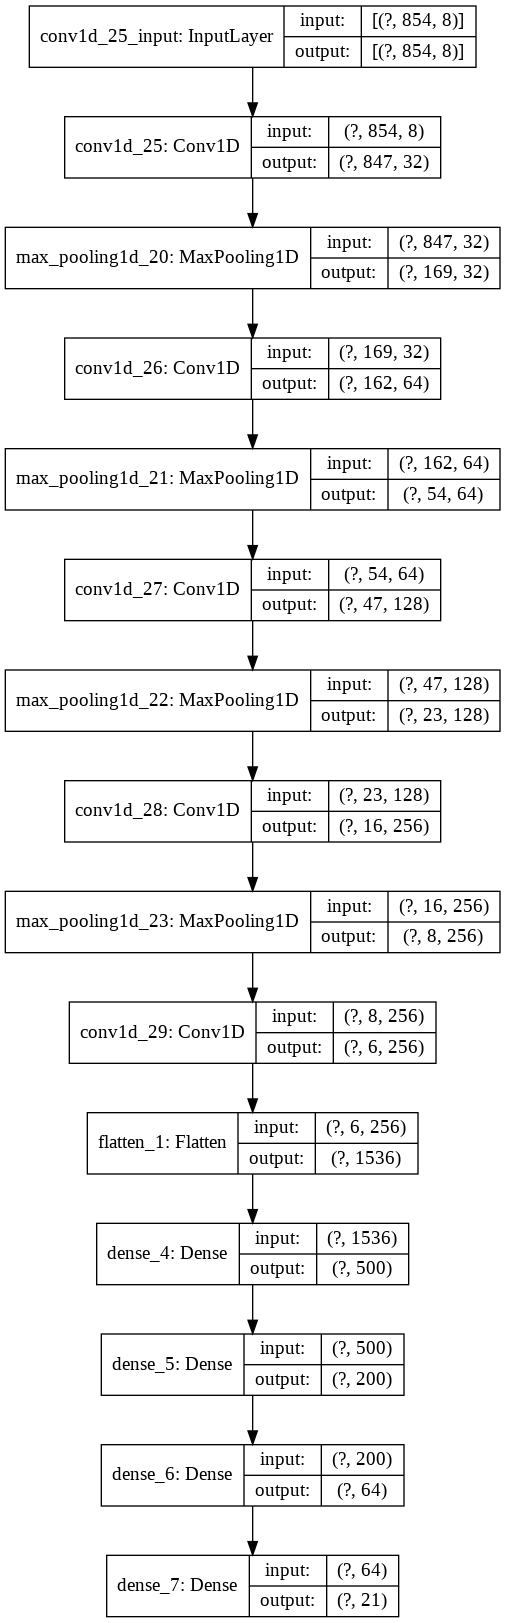

In [46]:
keras.utils.plot_model(model,'cov1_model.png',show_shapes=True)

In [47]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit_generator(train_dataset, epochs=10, 
                    validation_data=val_dataset)

Epoch 1/10
361/361 [==============================] - 25s 70ms/step - loss: 2.7653 - accuracy: 0.3590 - val_loss: 2.8098 - val_accuracy: 0.3133
Epoch 2/10
361/361 [==============================] - 23s 65ms/step - loss: 2.7625 - accuracy: 0.3613 - val_loss: 2.8098 - val_accuracy: 0.3133
Epoch 3/10
361/361 [==============================] - 24s 65ms/step - loss: 2.7625 - accuracy: 0.3613 - val_loss: 2.8098 - val_accuracy: 0.3133
Epoch 4/10
361/361 [==============================] - 24s 65ms/step - loss: 2.7625 - accuracy: 0.3613 - val_loss: 2.8098 - val_accuracy: 0.3133
Epoch 5/10
361/361 [==============================] - 24s 66ms/step - loss: 2.7625 - accuracy: 0.3613 - val_loss: 2.8098 - val_accuracy: 0.3133
Epoch 6/10
361/361 [==============================] - 23s 65ms/step - loss: 2.7625 - accuracy: 0.3613 - val_loss: 2.8098 - val_accuracy: 0.3133
Epoch 7/10
361/361 [==============================] - 23s 65ms/step - loss: 2.7625 - accuracy: 0.3613 - val_loss: 2.8098 - val_accuracy:

In [48]:
history.history

{'accuracy': [0.3590455,
  0.36126527,
  0.36126527,
  0.36126527,
  0.36126527,
  0.36126527,
  0.36126527,
  0.36126527,
  0.36126527,
  0.36126527],
 'loss': [2.764675238156292,
  2.7619048043440504,
  2.7619048043440504,
  2.7619048043440504,
  2.7619048043440504,
  2.7619048043440504,
  2.7619048043440504,
  2.7619048043440504,
  2.7619048043440504,
  2.7619048043440504],
 'val_accuracy': [0.31333333,
  0.31333333,
  0.31333333,
  0.31333333,
  0.31333333,
  0.31333333,
  0.31333333,
  0.31333333,
  0.31333333,
  0.31333333],
 'val_loss': [2.80983673731486,
  2.80983673731486,
  2.80983673731486,
  2.80983673731486,
  2.80983673731486,
  2.80983673731486,
  2.80983673731486,
  2.80983673731486,
  2.80983673731486,
  2.80983673731486]}

好像没学到什么，没怎么变化
#模型评估

In [49]:
test_loss, test_acc =  model.evaluate_generator(test_dataset,steps=2)
print('成功率：',test_acc)
print('损失：', test_loss)

成功率： 0.5
损失： 2.623170018196106


In [36]:
for a,b  in test_dataset.take(5):
  pre_b  = model.predict(a)
  #print('原始：',b.numpy())
  #print('预测：',pre_b)
  print('原始：',np.argmax(b.numpy(),axis=-1))
  print('预测：',np.argmax(pre_b,axis=-1))
  print()

原始： [13 10 10 12 10]
预测： [10 10 10 10 10]

原始： [10 11  9 10 11]
预测： [10 10 10 10 10]

原始： [10 12  9 11 11]
预测： [10 10 10 10 10]

原始： [11 11 14  6 11]
预测： [10 10 10 10 10]

原始： [10 10 10 10 11]
预测： [10 10 10 10 10]



#尝试单项数据做预测

###数据生成器

In [0]:
def gen_column_data(file_path):
  #数据生成函数
  
  data = pd.read_csv(root_path/file_path)
  #将日期转为星期，我认为星期几对股票交易有影响
  #data['trade_date'] = pd.to_datetime(data['trade_date'],format='%Y%m%d').dt.dayofweek
  data.pop('trade_date')
  data.pop('ts_code') #去除股票代码
  #data.pop('vol')
  #data.pop('amount')
  data['vol'] = data['vol']/10000  #这两个值太大了，缩小10000倍
  data['amount'] = data['amount']/10000  #这两个值太大了，缩小10000倍
  target = data.pop('pct_chg')
  #target = data['pct_chg']

  #数据处理
  #data = data[1:RECORD] #前50天的数据做为参数
  data = data[1:61] #前50天的数据做为参数
  #target = target[:5][]
  pct_chg = pct_chg_category[round(target.values[0])] #返回的是涨跌幅分类

  pct_chg_one_hot = tf.one_hot(pct_chg,len(pct_chg_category))

  return data['close'].values,pct_chg_one_hot
  #return [data[column].values for column in data.columns],pct_chg_one_hot


def gen_train_clumn_data():
  for file_path in train_file_paths:
    #file_path = random.choice(train_file_paths)
    yield gen_column_data(file_path)

def gen_val_clumn_data():
  for file_path in val_file_paths:
    #file_path = random.choice(val_file_paths)
    yield gen_column_data(file_path)

def gen_test_clumn_data():
  for file_path in test_file_paths:
    yield gen_column_data(file_path)

In [67]:
[one_stock[column].values for column in one_stock.columns]

[array(['600689.SH', '600689.SH', '600689.SH', ..., '600689.SH',
        '600689.SH', '600689.SH'], dtype=object),
 array([1, 0, 4, ..., 2, 1, 0]),
 array([ 9.64,  9.52,  9.68, ..., 10.83, 10.84, 10.87]),
 array([ 9.97,  9.68,  9.68, ..., 10.89, 10.89, 10.87]),
 array([ 9.63,  9.41,  9.56, ..., 10.7 , 10.72, 10.7 ]),
 array([ 9.8 ,  9.66,  9.57, ..., 10.74, 10.84, 10.84]),
 array([ 9.66,  9.57,  9.61, ..., 10.84, 10.84, 10.91]),
 array([ 0.14,  0.09, -0.04, ..., -0.1 ,  0.  , -0.07]),
 array([ 1.4493,  0.9404, -0.4162, ..., -0.92  ,  0.    , -0.64  ]),
 array([38844.72, 17645.7 , 12860.69, ...,  2300.58,  1782.28,  3081.58]),
 array([38199.835, 16899.207, 12367.035, ...,  2477.65 ,  1922.997,
         3320.278])]

In [110]:
a = gen_column_data(file_paths[5])
a

(array([11.25, 11.19, 11.46, 11.48, 11.5 , 11.53, 11.62, 11.21, 10.19,
        10.11, 10.12, 10.36, 10.22,  9.87,  9.74,  9.49,  9.21,  9.15,
         9.11,  9.21,  9.18,  9.18,  9.07,  9.03,  9.11,  9.14,  9.37,
         9.35,  9.34,  9.5 ,  9.17,  9.16,  9.39,  9.43,  9.53,  9.61,
        10.12, 10.22, 10.21, 10.46, 10.65, 10.46, 10.18, 10.38, 10.5 ,
        10.71, 10.4 , 10.29, 10.26, 10.62, 10.55, 10.69, 10.55, 10.64,
        10.8 , 10.74, 10.83, 10.58, 10.7 , 10.4 ]),
 <tf.Tensor: shape=(21,), dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], dtype=float32)>)

In [0]:
open_input = keras.Input(shape=(10,),name='open')
open_output = keras.layers.Dense(5,activation='relu')(open_input)
open_output = keras.layers.Dense(3,activation='relu')(open_output)

high_input = keras.Input(shape=(10,),name='high')
high_output = keras.layers.Dense(5,activation='relu')(high_input)
high_output = keras.layers.Dense(3,activation='relu')(high_output)


columns_layers = keras.layers.concatenate([open_output,high_output])

pred_output = keras.layers.Dense(2,name='pred_output')(columns_layers)

model_test = keras.Model(inputs=[open_input,high_input],
                         outputs=pred_output)



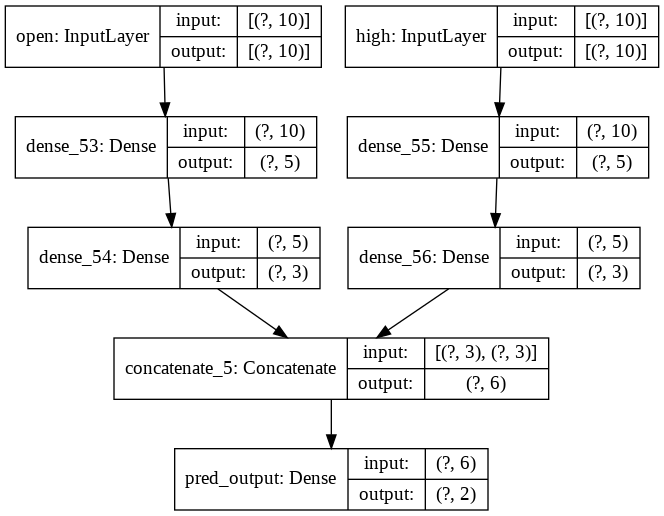

In [101]:
keras.utils.plot_model(model_test,'model_test.png',show_shapes=True)

In [0]:
def make_model(input_shape=(60,)):
  model = keras.Sequential([
    keras.layers.Dense(30,input_shape=input_shape),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(25,activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(21,activation='softmax'),
    #keras.layers.Dense(20,activation='relu'),
    #keras.layers.Dropout(0.2),
    #keras.layers.Dense(20,activation='relu'),
    #keras.layers.Dropout(0.2),
    #keras.layers.Dense(5,activation='relu'),
    #keras.layers.Dropout(0.2),
    #keras.layers.Dense(1,activation='softmax'),
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  return model


column_names = ['open', 'high', 'low', 'close', 'pre_close',
       'change', 'pct_chg', 'vol', 'amount']


In [0]:
close_model = make_model(input_shape=(60,))


train_column_dataset = tf.data.Dataset.from_generator(gen_train_clumn_data,output_types=(tf.float32,tf.float32),output_shapes=((60,),(21,)))
val_column_dataset = tf.data.Dataset.from_generator(gen_val_clumn_data,output_types=(tf.float32,tf.float32),output_shapes=((60,),(21,)))
test_column_dataset = tf.data.Dataset.from_generator(gen_test_clumn_data,output_types=(tf.float32,tf.float32),output_shapes=((60,),(21,)))
train_column_dataset = train_column_dataset.batch(10)
val_column_dataset = val_column_dataset.batch(10)
test_column_dataset = test_column_dataset.batch(10)

In [141]:
close_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_103 (Dense)            (None, 30)                1830      
_________________________________________________________________
dropout_32 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_104 (Dense)            (None, 25)                775       
_________________________________________________________________
dropout_33 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_105 (Dense)            (None, 21)                546       
Total params: 3,151
Trainable params: 3,151
Non-trainable params: 0
_________________________________________________________________


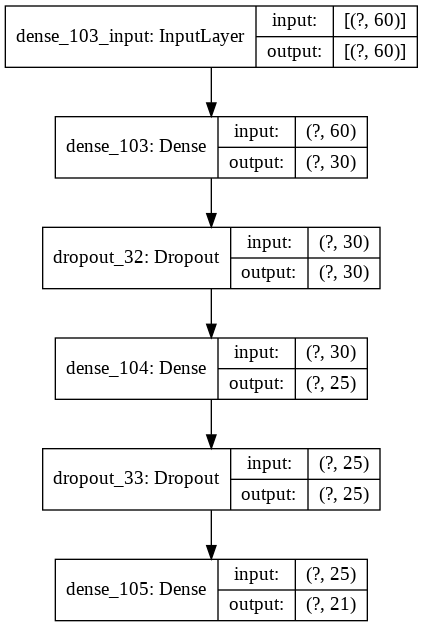

In [142]:
keras.utils.plot_model(close_model,'close_model.png',show_shapes=True)

In [138]:
for a,b in train_column_dataset.take(1):
  print(a)
  print(b)  

tf.Tensor(
[[ 6.18  6.11  6.2   6.2   6.2   6.25  6.47  6.56  6.38  6.53  6.46  6.27
   6.34  6.46  6.5   6.51  6.44  6.56  6.58  6.69  6.55  6.65  6.49  6.43
   6.37  6.4   6.4   6.56  6.18  6.2   5.96  6.08  6.29  6.57  6.66  6.74
   6.86  6.83  6.7   6.77  6.85  6.89  6.9   6.91  6.98  7.04  6.97  6.99
   6.97  6.95  6.92  7.06  7.18  7.36  7.6   7.71  7.55  7.25  7.11  7.1 ]
 [ 5.85  5.82  5.96  5.94  5.78  5.68  5.81  5.96  5.94  5.96  5.87  5.73
   5.69  5.71  5.81  5.66  5.56  5.5   5.36  5.39  5.4   5.45  5.42  5.53
   5.33  5.28  5.49  5.69  5.6   5.67  5.49  5.47  5.56  5.48  5.63  5.56
   5.87  6.2   6.15  6.28  6.1   5.92  5.91  6.07  5.89  6.12  5.71  5.59
   5.63  5.12  5.03  5.13  5.25  5.25  5.31  5.36  5.19  5.18  5.14  5.1 ]
 [ 6.96  6.86  6.86  6.81  6.84  6.84  6.94  6.93  6.92  6.98  6.92  6.94
   6.88  6.8   6.8   6.86  6.8   6.83  6.81  6.87  6.75  6.7   6.72  6.78
   6.77  6.77  6.73  6.87  7.01  7.    7.05  6.99  7.11  7.1   6.89  6.82
   6.88  7.03  6.69  6.63

In [143]:
close_history = close_model.fit(train_column_dataset,
                                validation_data=val_column_dataset,
                                epochs=10)

Epoch 1/10
181/181 [==============================] - 23s 125ms/step - loss: 2.7681 - accuracy: 0.3568 - val_loss: 2.8098 - val_accuracy: 0.3133
Epoch 2/10
181/181 [==============================] - 22s 122ms/step - loss: 2.7639 - accuracy: 0.3607 - val_loss: 2.8098 - val_accuracy: 0.3133
Epoch 3/10
181/181 [==============================] - 22s 123ms/step - loss: 2.7635 - accuracy: 0.3613 - val_loss: 2.8098 - val_accuracy: 0.3133
Epoch 4/10
181/181 [==============================] - 22s 122ms/step - loss: 2.7635 - accuracy: 0.3613 - val_loss: 2.8098 - val_accuracy: 0.3133
Epoch 5/10
181/181 [==============================] - 22s 123ms/step - loss: 2.7640 - accuracy: 0.3607 - val_loss: 2.8098 - val_accuracy: 0.3133
Epoch 6/10
181/181 [==============================] - 22s 122ms/step - loss: 2.7635 - accuracy: 0.3613 - val_loss: 2.8098 - val_accuracy: 0.3133
Epoch 7/10
181/181 [==============================] - 22s 124ms/step - loss: 2.7635 - accuracy: 0.3613 - val_loss: 2.8098 - val_ac